In [1]:
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('data/senti140.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [11]:
PREPROCESSED_DF = "preprocessed.pkl"
WORD2VEC_MODEL = "model.w2v"

In [3]:
# removing columns which are not being used
df.drop('ids', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('flag', axis=1, inplace=True)
df.drop('user', axis=1, inplace=True)

In [4]:
df.text.head()[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

# Preprocessing Data

## Removing Special Characters, Stop Words, and Lemmatizing Words

In [5]:
import re

In [6]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
STOP_WORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    words = word_tokenize(text) # tokenized words
    
    filter_text = [w for w in words if not w in STOP_WORDS]
    
    for text in filter_text:
        text = lemmatizer.lemmatize(text)
    
    return " ".join(filter_text)

In [7]:
print(df.text.head()[0])
preprocess(df.text.head()[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


'awww bummer shoulda got david carr third day'

In [8]:
# apply to all rows
df.text = df.text.apply(lambda x: preprocess(x))
df.head()

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


In [12]:
# saving to pickle, for easier access later. preprocess() takes long time to run
df.to_pickle(PREPROCESSED_DF)

In [13]:
df = pd.read_pickle(PREPROCESSED_DF)
df.head()

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


# Understanding/Modifying the Data 

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import random

<BarContainer object of 2 artists>

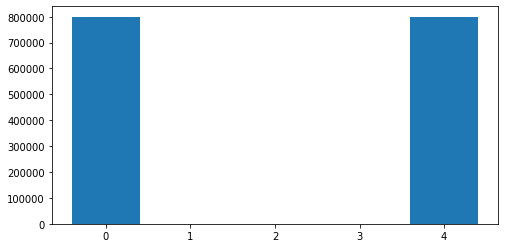

In [20]:
senti_cnt = Counter(df.sentiment)
plt.figure(figsize=(8,4))
plt.bar(senti_cnt.keys(), senti_cnt.values())

In [19]:
# 0 negative, 4 positive

In [23]:
# random rows from the df
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)]
df.loc[random_idx_list,:].head(10)

,sentiment,text
125527,0,lucas know girl called britta sorry bother soo...
673707,0,works ni mob always move meetings u
68554,0,real sad ff
1036828,4,cool cool looking forward
564128,0,today boring
296833,0,pizzza gym though decisions everyday lol
888963,4,showing u love sharing fav pic u taken love se...
1501977,4,sex city movie never gets oldddd
339399,0,food poisioning isnt great
621579,0,find literary agent book


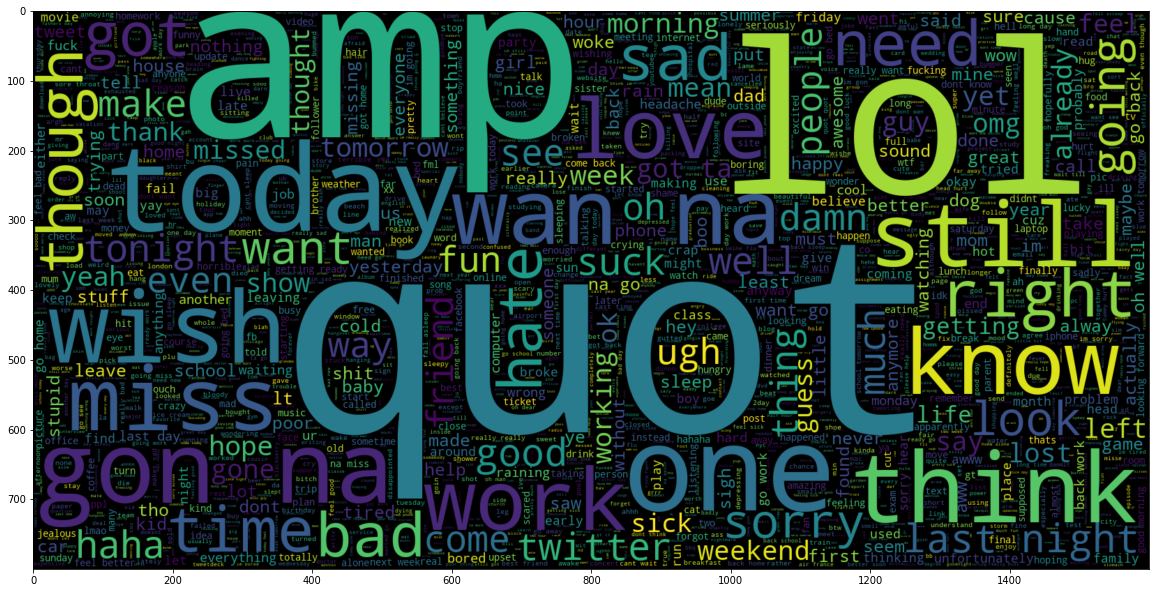

In [24]:
# negative words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

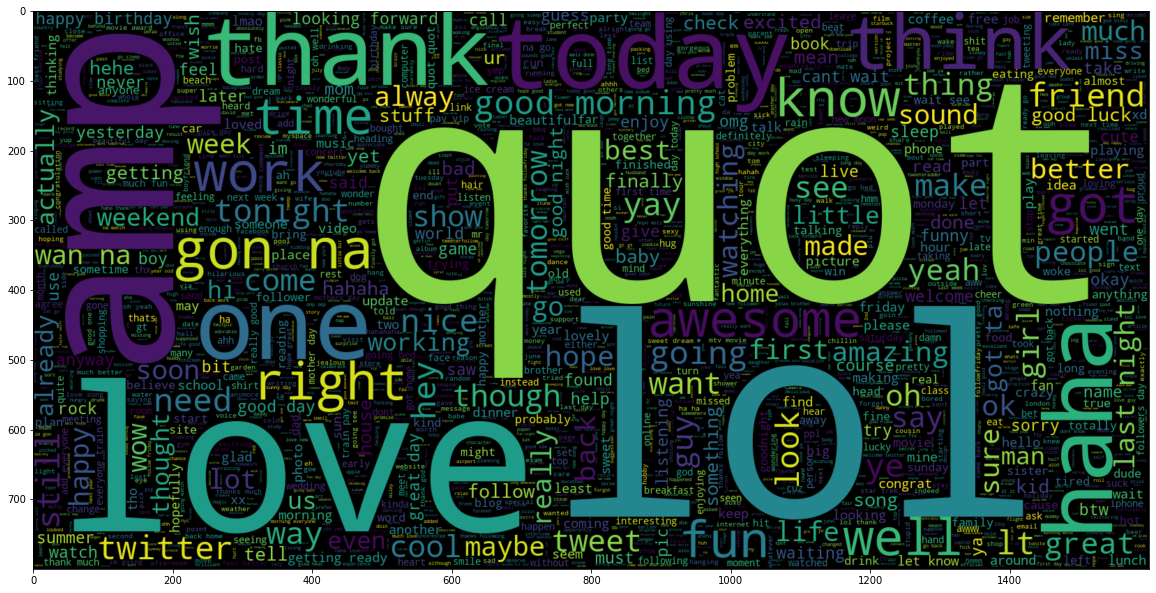

In [25]:
# positive words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 4].text))
plt.imshow(wc , interpolation = 'bilinear')

In [26]:
# amp, quot, lol are too common for both negative and positive words. Lets remove these in order to improve the dataset

In [37]:
words = set(["amp", "quot", "lol"])
def remove(words, text):
    """
    set -> None
    """
    remove = '|'.join(words)
    regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
    text = regex.sub("", text)
    return " ".join(text.split()) # corrects whitespaces

In [44]:
text = "gonna wanna one today still"
remove(words, text)

'gonna wanna one today still'

In [40]:
# apply to df
df.text = df.text.apply(lambda x: remove(words, x))

In [56]:
# drop all empty rows
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["text"], inplace=True)

In [58]:
df.to_pickle(PREPROCESSED_DF)

In [59]:
df = pd.read_pickle(PREPROCESSED_DF)
df.head()

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


# Split train and test